In [91]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from typing import List, Tuple
from numpy import shape
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [38]:
df = pd.read_csv('../datasets/cleaned_RNN_dataset.zip')
df.head()

,Unnamed: 0,track_id,track_name,track_artist,lyrics,track_album_id,track_album_name,playlist_name,playlist_id,playlist_genre,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,trees singing wind sky blue angels smiled saw ...,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,hard rock workout,3YouF0u7waJnolytf9JCXf,rock,...,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
1,2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,na yeah spyderman freeze full effect uh huh re...,6oZ6brjB8x3GoeSYdwJdPc,Gold,back day r b new jack swing swingbeat rnb etc,3a9y4eeCJRmG9p4YKfqYIx,r&b,...,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
2,3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,really can t stay baby cold outside i ve got g...,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,christmas soul,6FZYc2BvF7tColxO8PBShV,r&b,...,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
3,4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,get business keep turning witness criminal fee...,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,k party dance mix,37i9dQZF1DX4RDXswvP6Mj,pop,...,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en
4,5,00f9VGHfQhAHMCQ2bSjg3D,Soldier,James TW,hold breath look down keep trying darling okay...,3GNzXsFbzdwM0WKCZtgeNP,Chapters,urban contemporary,4WiB26kw0INKwbzfb5M6Tv,r&b,...,-6.157,1,0.0550,0.28000,0.00000,0.0975,0.305,147.764,224720,en


In [39]:
df.shape

(15405, 24)

audio_cols is a list of the audio metrics I want to work with.

In [40]:
audio_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

In the below code: 
1. I'm grouping the data frame based on the playlist ID's giving me each playlist as its own group.
2. Looping through each playlist and formatting them to 36 songs. So each playlist has a consistent 36 songs in them.
    - Playlists that have more than 36 songs are randomly reduced to 36.
    - Playlist that have less than 36 songs are padded with the average of the original playlist values until they are 36 songs.

In [41]:
# Group songs by playlist_id
grouped = df.groupby('playlist_id')

# Create an empty list to store the reshaped data
data = []

# 36 Was chosen because it was the average number of songs in each playlist.
max_songs_per_playlist = 36
n_features = 12

# Loop over each playlist and reshape the songs into rows
for playlist_id, group in grouped:
    # Get the songs for the current playlist and sort them by song_id
    songs = group.sort_values(by='track_id')
    
    # Calculate the number of songs in the playlist
    n_songs = songs.shape[0]

    # Calculate the number of rows we need for the playlist (assuming we want 50 songs per playlist)
    n_rows = np.ceil(n_songs / max_songs_per_playlist).astype(int)
    songs = pd.concat([songs]*n_rows).reset_index(drop=True)
    # Add the playlist_id to each row
    songs['playlist_id'] = playlist_id
       
    # Dropping all columns except for the audio metrics
    songs = songs.loc[:, audio_cols]
    
    # Determine the number of songs in current playlist
    num_songs_in_playlist = songs.shape[:2][0]
    
    if num_songs_in_playlist < max_songs_per_playlist:
        songs = songs.reindex(range(36), fill_value=0)
    elif num_songs_in_playlist > max_songs_per_playlist:
        songs = songs.drop(songs.sample(songs.shape[0] - 36).index)
    
    col_means = songs.mean()
    songs = songs.replace(0, col_means)
        
    # Add the playlist_id to each row
    songs['playlist_id'] = playlist_id
    data.append(songs)

In [42]:
def create_dependent_independent_vars(audio_metrics: np.ndarray, target_song_index: int):
    """
    Given a playlist, creates the dependent and independent variables (target data)

    Args:
    - audio_metrics: A 2D numpy array of shape (N, M), where N is the number of songs
        in the playlist and M is the number of audio metrics.
    - target_song_index: The index of the song to predict
    - target_song_audio_metrics: A 1D numpy array of shape (M, ) containing the audio metrics for the target song.

    Returns:
    - X: A 2D array containing the dependent variables, i.e the metrics of the audio data the model will use to determine the target variable.
    -Y: A 1D array containing the target auido metrics that the model is trying to predict.
    
    """
    # Remove the target song from the audio metrics array. The axis is set to zero to ensure that a row is removed and not a column.
    X = np.delete(audio_metrics, target_song_index, axis=0)

    # Remove the target song from the list of audio metrics
    Y = audio_metrics[target_song_index]

    return X, Y

The below code:
1. Loops through each playlist
2. Chooses a random song as the target variable
3. Delegates the rest of the songs as data the model will train on
4. Appends each dependent and independent variable match to a list

In [43]:
NUM_SONGS = 36

x_train_raw = []
y_train_raw = []

for i in range(len(data)):
    target_song_index = random.randint(0, NUM_SONGS-1)
    df = data[i]
    X, y = create_dependent_independent_vars(audio_metrics=df[audio_cols].values, target_song_index=target_song_index)
    x_train_raw.append(X)
    y_train_raw.append(y)

In [44]:
x_train_raw = np.array(x_train_raw)
y_train_raw = np.array(y_train_raw)

print(x_train_raw.shape)
print(y_train_raw.shape)

(423, 35, 12)
(423, 12)


Training Set (65%)
Validation Set (20%)
Testing Set (15%)

In [57]:
(X_train, X_test, y_train, y_test) = train_test_split(x_train_raw, y_train_raw, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [58]:
model = keras.models.Sequential(name="First-RNN-Model")
model.add(keras.Input(shape=(35,12), name="Input Layer"))
model.add(layers.SimpleRNN(64, activation='tanh', name="Hidden-Recurrent-Layer"))
model.add(layers.Dense(12, name="Output-Layer"))

print(model.summary())

Model: "First-RNN-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Recurrent-Layer (Sim  (None, 64)               4928      
 pleRNN)                                                         
                                                                 
 Output-Layer (Dense)        (None, 12)                780       
                                                                 
Total params: 5,708
Trainable params: 5,708
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None
)

In [84]:
model.fit(X_train, 
          y_train, 
          validation_data=(X_val, y_val),
          epochs=10, 
          batch_size=1
          )

Epoch 1/10
269/269 [==============================] - 2s 4ms/step - loss: 2.9587 - accuracy: 1.0000 - val_loss: 2.0713 - val_accuracy: 1.0000
Epoch 2/10
269/269 [==============================] - 1s 4ms/step - loss: 1.8614 - accuracy: 1.0000 - val_loss: 1.9890 - val_accuracy: 1.0000
Epoch 3/10
269/269 [==============================] - 1s 4ms/step - loss: 1.8133 - accuracy: 1.0000 - val_loss: 1.9889 - val_accuracy: 1.0000
Epoch 4/10
269/269 [==============================] - 1s 3ms/step - loss: 1.8133 - accuracy: 1.0000 - val_loss: 1.9889 - val_accuracy: 1.0000
Epoch 5/10
269/269 [==============================] - 1s 3ms/step - loss: 1.8133 - accuracy: 1.0000 - val_loss: 1.9889 - val_accuracy: 1.0000
Epoch 6/10
269/269 [==============================] - 1s 3ms/step - loss: 1.8133 - accuracy: 1.0000 - val_loss: 1.9889 - val_accuracy: 1.0000
Epoch 7/10
269/269 [==============================] - 1s 4ms/step - loss: 1.8133 - accuracy: 1.0000 - val_loss: 1.9889 - val_accuracy: 1.0000
Epoch 

In [90]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions.ravel(), 'Actuals':y_train.ravel()})
train_results

,Train Predictions,Actuals
0,-8778.963867,0.46600
1,-16746.076172,0.73900
2,-12111.460938,4.00000
3,-24079.933594,-6.78200
4,-29985.441406,1.00000
...,...,...
3223,-14155.075195,0.00052
3224,-16542.736328,0.33600
3225,-14224.674805,0.27400
3226,-14604.388672,122.02800


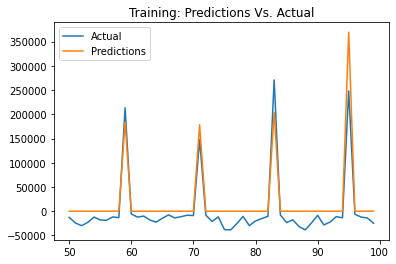

In [96]:
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])
plt.title('Training: Predictions Vs. Actual')
plt.legend(["Actual", "Predictions"])


In [97]:
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Validation Predictions':val_predictions.ravel(), 'Actuals':y_val.ravel()})
val_results

,Validation Predictions,Actuals
0,-476.509186,0.044083
1,-999.020508,0.041083
2,-846.548767,0.277778
3,-1543.401489,-0.260222
4,-1922.664673,0.027778
...,...,...
1075,-23941.328125,0.002833
1076,-23634.248047,0.588000
1077,-8106.932617,0.533000
1078,-11703.373047,170.004000


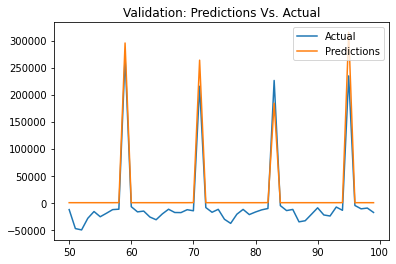

In [99]:
plt.plot(val_results['Validation Predictions'][50:100])
plt.plot(val_results['Actuals'][50:100])
plt.title('Validation: Predictions Vs. Actual')
plt.legend(["Actual", "Predictions"])

In [100]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Testing Predictions':test_predictions.ravel(), 'Actuals':y_test.ravel()})
test_results

,Testing Predictions,Actuals
0,-5740.039062,0.742000
1,-24166.464844,0.930000
2,-18656.318359,9.000000
3,-32934.191406,-3.669000
4,-41299.558594,1.000000
...,...,...
763,-406.198212,0.000000
764,-350.156403,0.009861
765,-245.727539,0.017389
766,-270.269806,3.608639


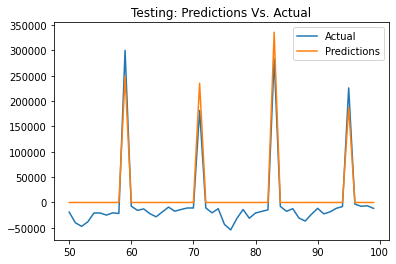

In [101]:
plt.plot(test_results['Testing Predictions'][50:100])
plt.plot(test_results['Actuals'][50:100])
plt.title('Testing: Predictions Vs. Actual')
plt.legend(["Actual", "Predictions"])

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      36 non-null     float64
 1   energy            36 non-null     float64
 2   key               36 non-null     float64
 3   loudness          36 non-null     float64
 4   mode              36 non-null     int64  
 5   speechiness       36 non-null     float64
 6   acousticness      36 non-null     float64
 7   instrumentalness  36 non-null     float64
 8   liveness          36 non-null     float64
 9   valence           36 non-null     float64
 10  tempo             36 non-null     float64
 11  duration_ms       36 non-null     float64
 12  playlist_id       36 non-null     object 
dtypes: float64(11), int64(1), object(1)
memory usage: 3.8+ KB
